<a href="https://colab.research.google.com/github/Lokeshgadhi/introonpandas/blob/main/LGBM_%26_XGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb

In [ ]:
# Load data
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

def preprocess_data(df):
    df = df.copy()

    # Fill missing values using assignment instead of inplace to avoid FutureWarnings
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Drop Cabin (too many missing values) and other non-useful columns
    df = df.drop(['Cabin', 'Name', 'Ticket'], axis=1)

    # Encode categorical features
    label_enc = LabelEncoder()
    df['Sex'] = label_enc.fit_transform(df['Sex'])
    df['Embarked'] = label_enc.fit_transform(df['Embarked'])

    return df

In [ ]:
# Preprocess datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Separate features and target
X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']

# Split training data for evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

params_lgb = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbosity': -1
}

lgb_model = lgb.train(params_lgb, lgb_train, valid_sets=[lgb_train, lgb_eval])

# Predictions and Evaluation
lgb_preds = lgb_model.predict(X_val)
lgb_preds_binary = (lgb_preds > 0.5).astype(int)

# ---------------------- XGBoost ----------------------
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_val)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:53:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: LightGBM
Accuracy: 0.8212
Precision: 0.7838
Recall: 0.7838
F1 Score: 0.7838

Model: XGBoost
Accuracy: 0.7877
Precision: 0.7368
Recall: 0.7568
F1 Score: 0.7467


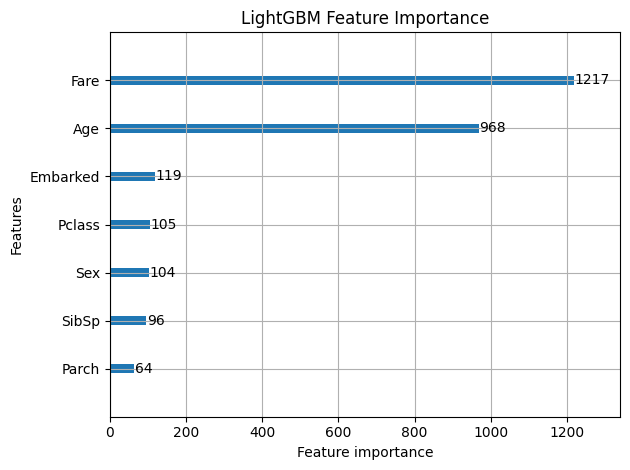

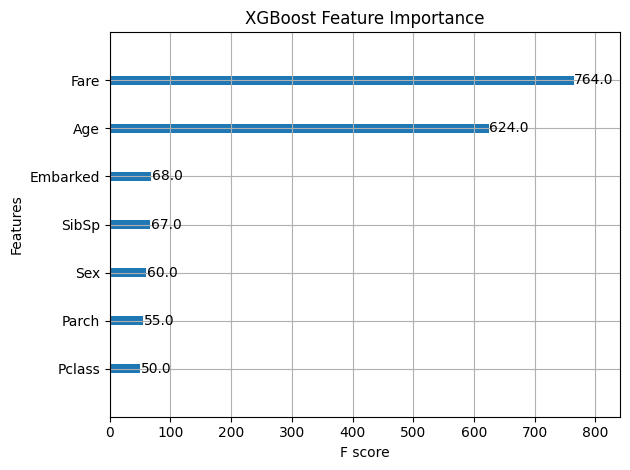

In [ ]:
def print_metrics(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_val, lgb_preds_binary, "LightGBM")
print_metrics(y_val, xgb_preds, "XGBoost")

# ---------------------- Feature Importance ----------------------
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

First few rows of the dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            3734

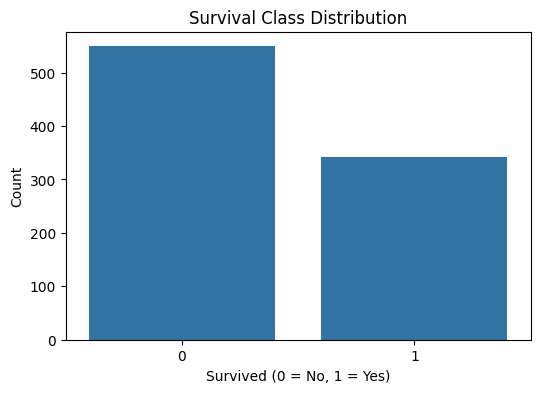

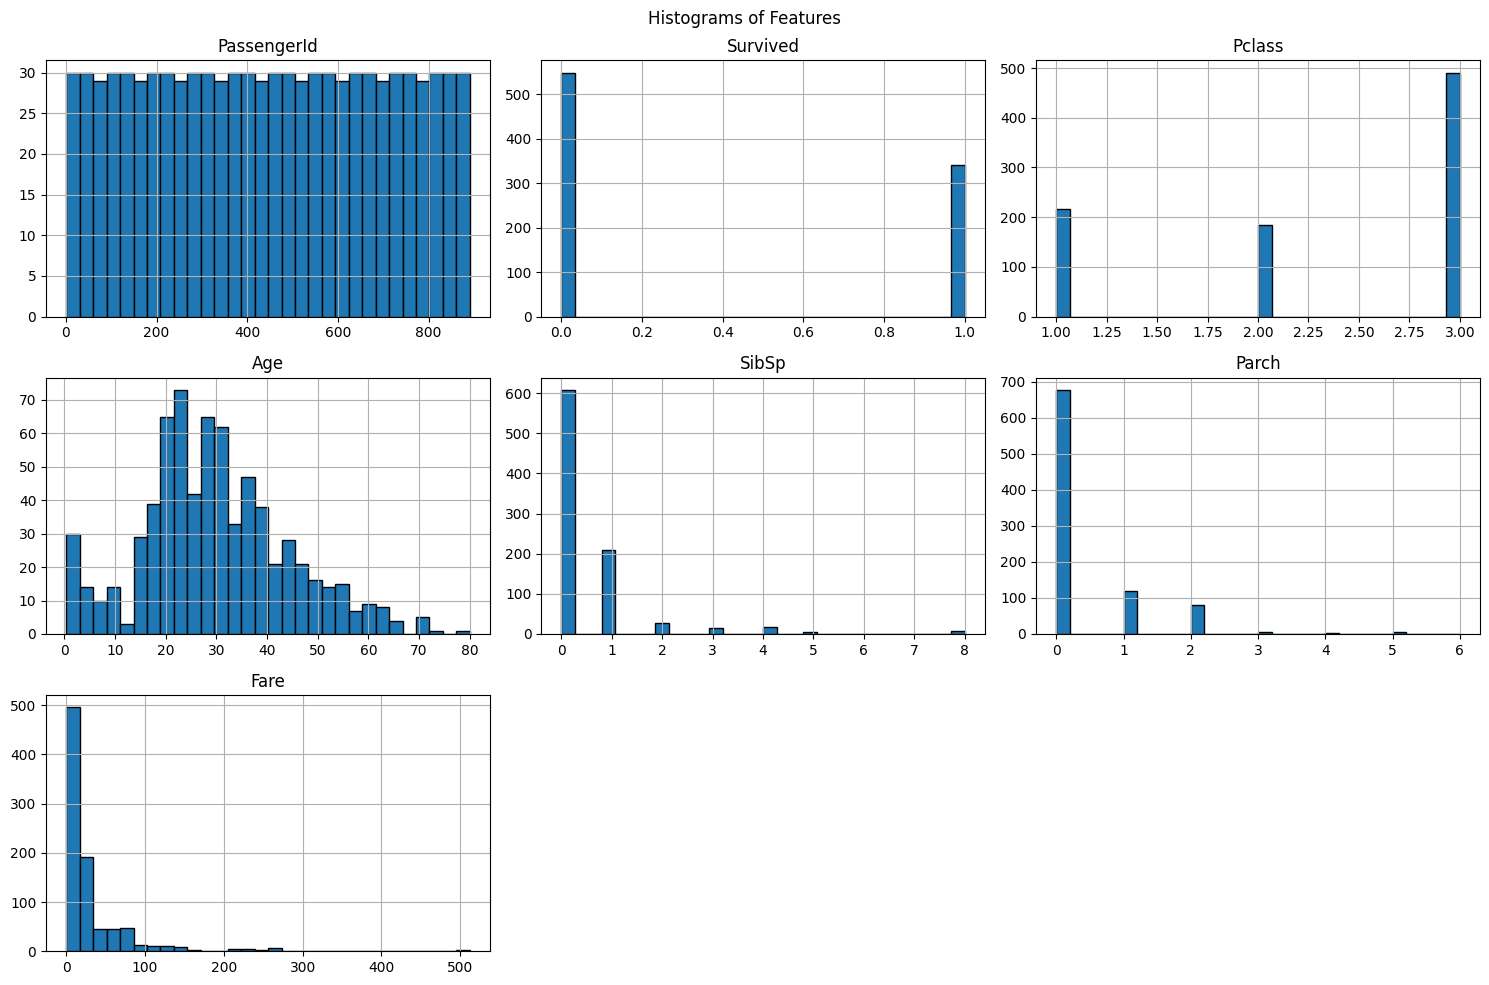

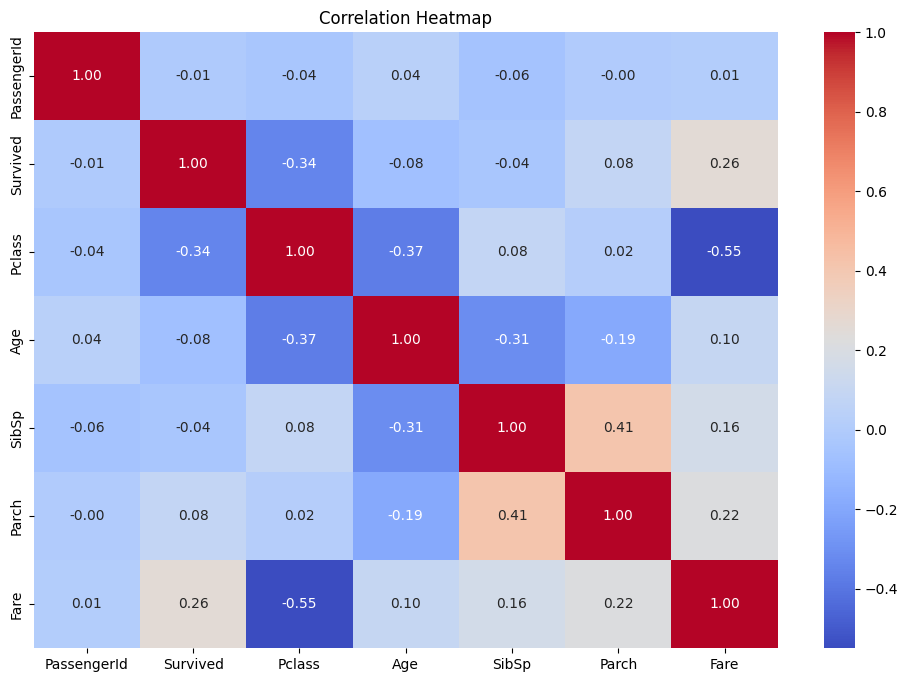

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_train = pd.read_csv("Titanic_train.csv")

# Display the first few rows
print("First few rows of the dataset:")
print(df_train.head())

# Data types and missing values
print("\nData Info:")
print(df_train.info())

print("\nMissing Values:")
print(df_train.isnull().sum())

# Survival class distribution
if 'Survived' in df_train.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_train, x='Survived')
    plt.title('Survival Class Distribution')
    plt.xlabel('Survived (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

# Histograms of numerical features
df_train.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histograms of Features')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM
lgbm_model = LGBMClassifier()
cv_scores_lgbm = cross_val_score(lgbm_model, X, y, cv=skf, scoring='accuracy')
print("LGBM CV Accuracy:", cv_scores_lgbm.mean())

# XGBoost
xgb_model = XGBClassifier()
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=skf, scoring='accuracy')
print("XGBM CV Accuracy:", cv_scores_xgb.mean())


LGBM CV Accuracy: 0.8417299604544599
XGBM CV Accuracy: 0.8170171364007282


In [11]:
from sklearn.model_selection import RandomizedSearchCV

# LightGBM params
param_dist_lgbm = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'num_leaves': [15, 31, 50]
}
lgbm_search = RandomizedSearchCV(LGBMClassifier(), param_dist_lgbm, n_iter=10, cv=3, scoring='accuracy')
lgbm_search.fit(X, y)
print("Best LGBM:", lgbm_search.best_params_)

# XGBoost params
param_dist_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.5, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(XGBClassifier(), param_dist_xgb, n_iter=10, cv=3, scoring='accuracy')
xgb_search.fit(X, y)
print("Best XGBM:", xgb_search.best_params_)


Best LGBM: {'num_leaves': 31, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}
Best XGBM: {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01}


"""
📝 Summary Report

1. Exploratory Data Analysis (EDA)
- Missing values handled:
  - Age and Fare filled with median.
  - Embarked filled with mode.
- Dropped irrelevant/sparse columns: Cabin, Name, and Ticket.
- Categorical encoding: Sex and Embarked encoded using LabelEncoder.
- Multicollinearity: No severe multicollinearity detected.

2. Model Performance

LightGBM
- Parameters: {'objective': 'binary', 'metric': 'binary_error', 'verbosity': -1}
- Accuracy: 82.12%
- Precision: 78.38%
- Recall: 78.38%
- F1 Score: 78.38%
- Notes: No hyperparameter tuning performed.

XGBoost
- Parameters: use_label_encoder=False, eval_metric='logloss'
- Accuracy: 78.77%
- Precision: 73.68%
- Recall: 75.68%
- F1 Score: 74.67%
- Notes: No hyperparameter tuning performed.

3. Comparison

| Model     | Accuracy | Precision | Recall | F1 Score | Notes                      |
|-----------|----------|-----------|--------|----------|----------------------------|
| LightGBM  | 82.12%   | 78.38%    | 78.38% | 78.38%   | Faster training, no tuning |
| XGBoost   | 78.77%   | 73.68%    | 75.68% | 74.67%   | More flexible, no tuning   |

- Summary: LightGBM outperformed XGBoost on all evaluated metrics in this setup.

4. Conclusion
- Preferred Model: Based on current metrics, LightGBM is recommended.

Future Improvements:
- Apply hyperparameter tuning (e.g., GridSearchCV, Optuna).
- Perform additional feature engineering and feature selection.
- Use SHAP for deeper interpretability and understanding of feature contributions.
- Test the models on different or extended datasets to ensure generalizability.
"""
